## Setting Data Directory

In [4]:
data_dir = '/kaggle/input/violence-nonviolence/Real_Life_Violence_Dataset'

## Setting Imports

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LSTM, TimeDistributed, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
import numpy as np
from matplotlib import pyplot as plt
import cv2

## Setting Constants

In [6]:
img_height, img_width= 100,100  
seed = 42
batch_size = 8
SEQUENCE_LEGNTH = 16
CLASS_LIST = ['Violence','NonViolence']

In [7]:
print(tf.__version__)

2.16.1


## Data Preprocessing

In [ ]:
def extract_frames(video_path):
    
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames//SEQUENCE_LEGNTH,1)
    
    for i in range(SEQUENCE_LEGNTH):
        
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
        
        ret,frame = video_reader.read()
        if not ret:
            break
            
        resized_frame = cv2.resize(frame,(img_height,img_width))
        
        normalized_frame = resized_frame / 255.0
        
        frames.append(normalized_frame)
        
    video_reader.release()
    
    return frames
        

In [ ]:
def create_dataset(max_vid_per_class = 750):
    
    features = []
    labels = []
    
    for class_index,class_name in enumerate(CLASS_LIST):
        
        print(f"Extracting Data of Class:{class_name}")
        
        files_list = os.listdir(os.path.join(data_dir,class_name))
        
        count = 0
        for filename in files_list:
            if count >= max_vid_per_class:
                break
            
            video_path = os.path.join(data_dir,class_name,filename)
            frames = extract_frames(video_path)
            
            if len(frames) == SEQUENCE_LEGNTH:
                
                features.append(frames)
                labels.append(class_index)
                count += 1
                
    features = np.asarray(features)
    labels = np.array(labels)
    
    return features, labels 

In [10]:
features,labels=create_dataset()

Extracting Data of Class:Violence
Extracting Data of Class:NonViolence


[h264 @ 0x5c3c9dfe5680] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5c3c9dfe5680] error while decoding MB 98 31
[h264 @ 0x5c3c9dfe5680] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5c3c9dfe5680] error while decoding MB 98 31
[h264 @ 0x5c3c9dfe5680] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5c3c9dfe5680] error while decoding MB 98 31
[h264 @ 0x5c3c9dfe5680] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5c3c9dfe5680] error while decoding MB 98 31


## Extracting features

In [11]:
np.save('features.npy',features)
np.save('labels.npy',labels)

In [12]:
#features = np.load('/kaggle/working/features.npy')
#labels = np.load('/kaggle/working/labels.npy')

### One Hot Encoding Labels

In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [14]:
features_train,features_temp,labels_train,labels_temp = train_test_split(features, labels, 
                                                                        test_size=0.2,shuffle=True,
                                                                        random_state=seed)

In [15]:
features_val,features_test,labels_val,labels_test = train_test_split(features_temp, labels_temp, 
                                                                        test_size=0.5,shuffle=True,
                                                                        random_state=seed)

In [16]:
ohc_labels_train = to_categorical(labels_train)
ohc_labels_val = to_categorical(labels_val)
ohc_labels_test = to_categorical(labels_test)

## Creating the Xception Model + LSTM

In [17]:
base_model = Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(100, 100, 3))

base_model.trainable = False

for layer in base_model.layers[-5:]:  
    layer.trainable = True

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten

model = Sequential()

model.add(Input(shape=(16, 100, 100, 3)))
model.add(TimeDistributed(base_model))    
model.add(Dropout(0.25))                    

model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(LSTM (64, activation='tanh', return_sequences=False))

# Dense Layer
model.add(Dense (128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense (64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(2,activation='softmax'))  
                     
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, 16, 100, 100, 3))


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │    20,861,480 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 3,166,720 (12.08 MB)

 Non-trainable params: 17,694,760 (67.50 MB)

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [21]:
checkpoint_callback = ModelCheckpoint(
    filepath = 'xception_lstm.keras',
    save_weights_only = False,
    monitor='val_accuracy',
    mode = 'max',
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',  
                              factor=0.5,          
                              patience=7,          
                              min_lr=0.00001,         
                              verbose=1)


In [22]:
history = model.fit(x = features_train,
                    y = ohc_labels_train,
                    batch_size = batch_size,
                   epochs = 50,
                   validation_data = (features_val,ohc_labels_val),
                    shuffle=True,
                   callbacks=[checkpoint_callback,reduce_lr])

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 109s 350ms/step - accuracy: 0.6489 - loss: 0.6507 - val_accuracy: 0.8533 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.8211 - loss: 0.3799 - val_accuracy: 0.8400 - val_loss: 0.3405 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - accuracy: 0.8389 - loss: 0.3682 - val_accuracy: 0.9067 - val_loss: 0.2375 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.9245 - loss: 0.2161 - val_accuracy: 0.9067 - val_loss: 0.1902 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - accuracy: 0.9433 - loss: 0.1816 - val_accuracy: 0.9200 - val_loss: 0.2208 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 267ms/step - accuracy: 0.9482 - loss: 0.1387 - val_accuracy: 0.9267 - val_loss: 0.2250 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - accuracy: 0.

In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

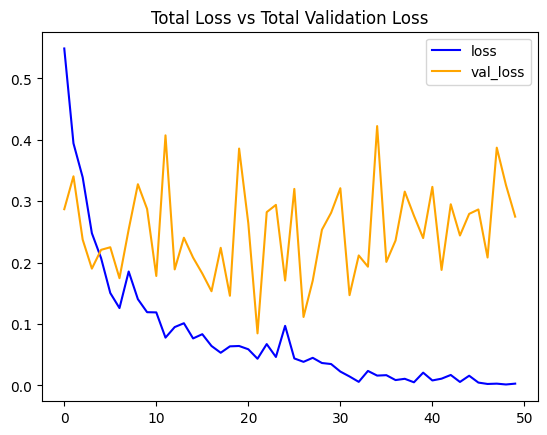

In [24]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

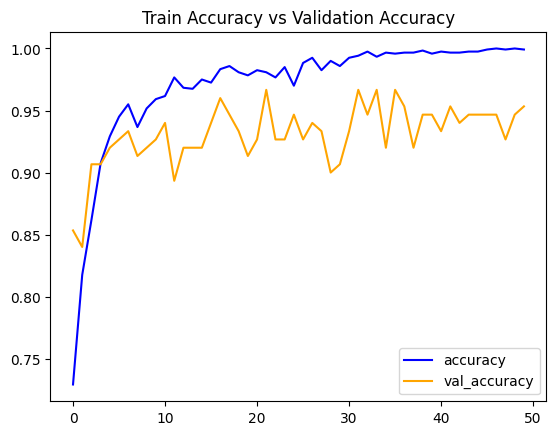

In [25]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Train Accuracy vs Validation Accuracy')

In [26]:
model.save_weights('Xception_LSTM.weights.h5')

## Test

In [27]:
import time

In [28]:
print("labels_test shape:", labels_test.shape)
print("features_test shape:", features_test.shape)

labels_test shape: (150,)
features_test shape: (150, 16, 100, 100, 3)


In [29]:
start_time = time.perf_counter()
loss, accuracy = model.evaluate(features_test, ohc_labels_test)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 633ms/step - accuracy: 0.9632 - loss: 0.2482
Elapsed time: 4.722429 seconds
Test Loss: 0.30267760157585144
Test Accuracy: 0.95333331823349


In [30]:
labels_predict = model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(ohc_labels_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step 


In [31]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9533333333333334


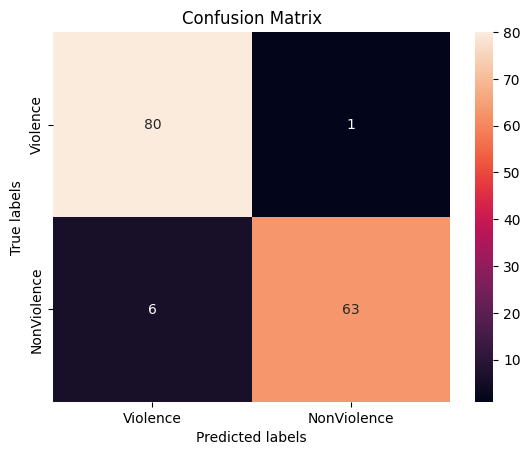

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Violence', 'NonViolence'])
ax.yaxis.set_ticklabels(['Violence', 'NonViolence'])

plt.savefig('/kaggle/working/confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

plt.show()